### 4.1 Contents<a id='4.1_Contents'></a>

  * [4.2 Load The Data](#4.2_Load_The_Data)      
  * [4.3 Future forcast](#4.3_Future_forcast)
  * [4.4 AutoML MLjar](#4.4_AutoML_mljar)
  * [4.5 Final Result](#4.5_Final_Result)
  * [4.6 Summary](#4.6_Summary)
  

[<a href="#4.1_Contents">Back to top</a>] 

In [1]:
import pandas as pd
import pickle
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.neighbors import KNeighborsRegressor

### 4.2  Load The Data<a id='4.2_Load_The_Data'></a>     

In [2]:
train_df= pd.read_pickle("./Data/train.pkl")
test_df = pd.read_pickle("./Data/test.pkl")

In [3]:
display(train_df.tail(3), test_df.head(3),test_df.tail(3))

,Call count
Date,
2021-04-30,241648
2021-05-31,274411
2021-06-30,301378


,Call count,Predicted_SARIMA
Date,,
2021-07-31,303152,291495.120045
2021-08-31,282244,295038.668380
2021-09-30,317507,287908.662812


,Call count,Predicted_SARIMA
Date,,
2022-10-31,267062,260829.243717
2022-11-30,246526,258502.211451
2022-12-31,260642,256552.200656


### 4.3  Future forcast<a id='4.3_Future_forcast'></a>     

[<a href="#4.1_Contents">Back to top</a>] 

C:\Users\asiya\anaconda3\envs\cp3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
C:\Users\asiya\anaconda3\envs\cp3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
C:\Users\asiya\anaconda3\envs\cp3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\asiya\anaconda3\envs\cp3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Text(0.5, 1.0, 'SARIMA predicted Calls')

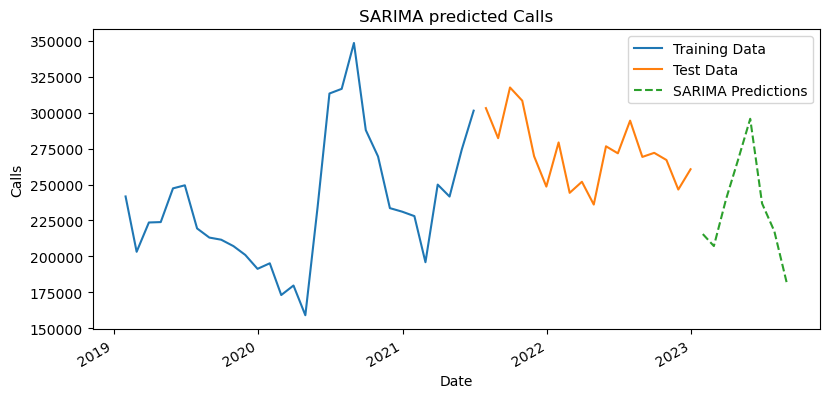

In [4]:
model_SARIMA = SARIMAX(train_df["Call count"], order=(1, 1, 1), seasonal_order=(0, 1, 0, 11))
model_SARIMA_fit = model_SARIMA.fit()
pred_dates = pd.date_range(start="2023-01-31", end="2023-08-31", freq="M")
pred_df = pd.DataFrame({'Date': pred_dates, 'calls': model_SARIMA_fit.predict(start=pred_dates[0], end=pred_dates[-1])})
pred_df.set_index('Date', inplace=True)

fig, ax1 = plt.subplots(figsize=(8, 4))
fig.tight_layout()
fig.autofmt_xdate()

# plot the training data, testing data, and predictions
ax1.set_xlabel("Date")
ax1.set_ylabel("Calls")
ax1.plot(train_df["Call count"], label="Training Data")
ax1.plot(test_df["Call count"], label="Test Data")
ax1.plot(pred_df ['calls'], label="SARIMA Predictions", ls='--')
ax1.legend()
ax1.set_title("SARIMA predicted Calls")

### 4.4  AutoML MLjar<a id='4.4_AutoML_MLjar'></a>     

[<a href="#4.1_Contents">Back to top</a>] 

In [5]:
from supervised.automl import AutoML

# Load your time series data into train_df and test_df
# Assuming 'Call count' is the column with call counts and 'Date' is the index

# Create a lagged version of the time series data as additional features
def create_lagged_features(data, lag):
    for i in range(1, lag+1):
        data[f'Call count Lag-{i}'] = data['Call count'].shift(i)
    return data.dropna()

lag = 11  # Choose the lag for the lagged features
train_lagged = create_lagged_features(train_df, lag)
test_lagged = create_lagged_features(test_df, lag)

# Prepare data for AutoML
X_train = train_lagged.drop('Call count', axis=1)
y_train = train_lagged['Call count']
X_test = test_lagged.drop('Call count', axis=1)
y_test = test_lagged['Call count']

# Initialize and train AutoML
automl = AutoML(mode='Compete')
automl.fit(X_train, y_train)

# Make predictions using AutoML
predictions = automl.predict(X_test)

# Evaluate AutoML model
rmse = ((predictions - y_test) ** 2).mean() ** 0.5
print(f"Root Mean Squared Error (RMSE): {rmse}")

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


AutoML directory: AutoML_3
The task is multiclass_classification with evaluation metric logloss
AutoML will use algorithms: ['Decision Tree', 'Linear', 'Random Forest', 'Extra Trees', 'LightGBM', 'Xgboost', 'CatBoost', 'Neural Network', 'Nearest Neighbors']
AutoML will stack models
AutoML will ensemble available models
AutoML steps: ['adjust_validation', 'simple_algorithms', 'default_algorithms', 'not_so_random', 'golden_features', 'kmeans_features', 'insert_random_feature', 'features_selection', 'hill_climbing_1', 'hill_climbing_2', 'boost_on_errors', 'ensemble', 'stack', 'ensemble_stacked']
* Step adjust_validation will try to check up to 1 model
1_DecisionTree logloss 2.334817 trained in 0.73 seconds
Adjust validation. Remove: 1_DecisionTree
*** Disable stacking for small dataset (nrows < 500)
Validation strategy: 10-fold CV Shuffle,Stratify
* Step simple_algorithms will try to check up to 4 models
1_DecisionTree logloss 2.334817 trained in 1.92 seconds
2_DecisionTree logloss 2.1379

C:\Users\asiya\anaconda3\envs\cp3\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.


Ensemble logloss 1.8e-05 trained in 3.29 seconds
AutoML fit time: 26926.28 seconds
AutoML best model: 11_Default_NearestNeighbors
Root Mean Squared Error (RMSE): 40212.89975510701


<font color=blue> MLjar suggested Default_NearestNeighbors with a Root Mean Squared Error (RMSE) of 40212.89 as the best model overall. Therefore, we will plot and visualize the results for this model.

### KNeighborsRegressor recomended by MLjar

In [6]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Function to create lagged features
def create_lagged_features(data, lag):
    for i in range(1, lag + 1):
        data[f'Call count Lag-{i}'] = data['Call count'].shift(i)
    return data.dropna()

lag = 11  # Choose the lag for the lagged features

# Assuming you have train_df and test_df dataframes
train_lagged = create_lagged_features(train_df, lag)
test_lagged = create_lagged_features(test_df, lag)

# Prepare data for KNeighborsRegressor model
X_train = train_lagged.drop('Call count', axis=1)
y_train = train_lagged['Call count']
X_test = test_lagged.drop(['Call count','Predicted_SARIMA'], axis=1)
y_test = test_lagged['Call count']

# Initialize KNeighborsRegressor model
knn_regressor = KNeighborsRegressor(n_neighbors=5)  # You can adjust the number of neighbors

# Fit KNeighborsRegressor model
knn_regressor.fit(X_train, y_train)

# Predict Call count using KNeighborsRegressor
predictions = knn_regressor.predict(X_test)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, predictions))
# Calculate MAPE
mape = np.mean(np.abs((y_test - predictions) / y_test)) * 100

# Calculate MAE
mae = mean_absolute_error(y_test, predictions)

print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"Mean Absolute Error (MAE): {mae}")



Root Mean Squared Error (RMSE): 33286.29616755649
Mean Absolute Percentage Error (MAPE): 10.88%
Mean Absolute Error (MAE): 29864.600000000002


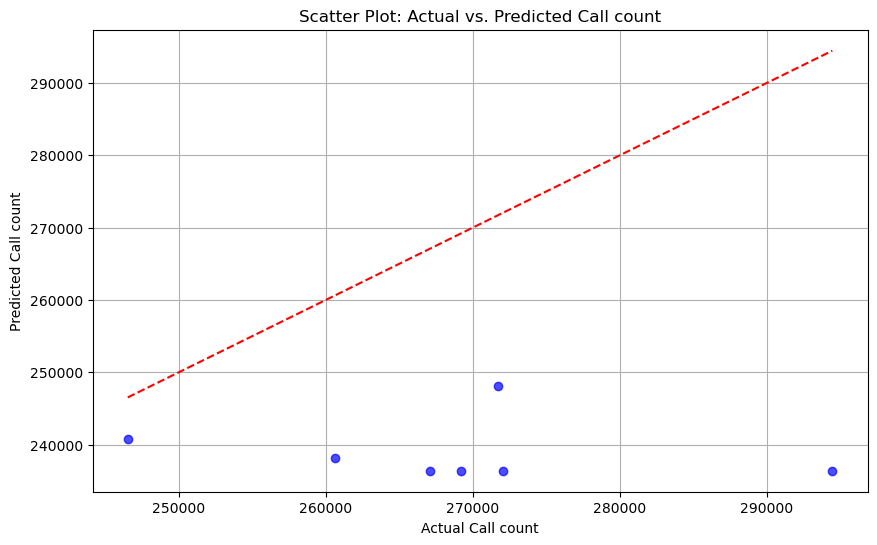

In [7]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, predictions, color='blue', alpha=0.7)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')  # 45-degree line
plt.xlabel('Actual Call count')
plt.ylabel('Predicted Call count')
plt.title('Scatter Plot: Actual vs. Predicted Call count')
plt.grid(True)
plt.show()


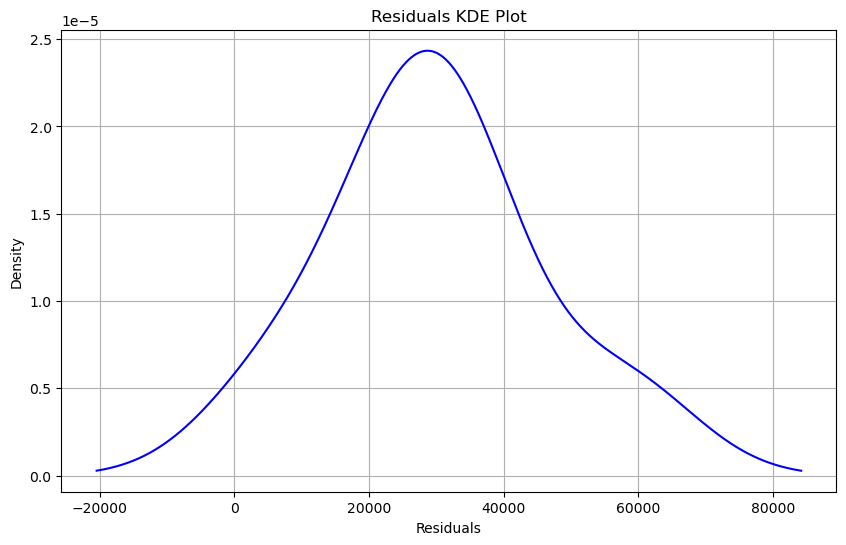

In [8]:
residuals = y_test - predictions

# Plot KDE plot of residuals
plt.figure(figsize=(10, 6))
residuals.plot(kind='kde', color='blue')
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.title('Residuals KDE Plot')
plt.grid(True)
plt.show()

### 4.5 Final Result:<a id='4.5_Final_Result'></a>     

C:\Users\asiya\AppData\Local\Temp\ipykernel_18428\930659969.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


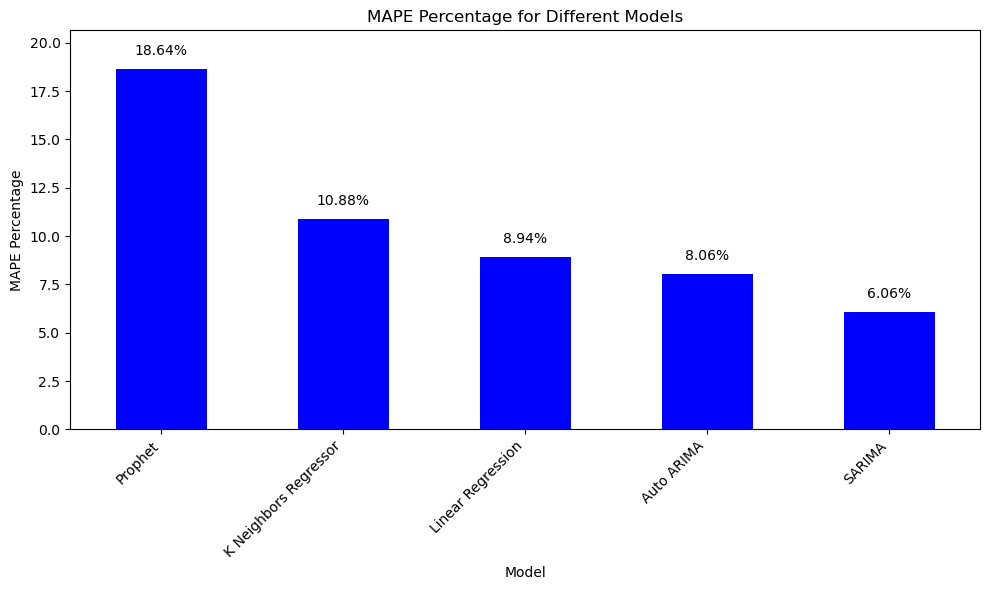

In [9]:
new_row = pd.DataFrame({'RMSE': rmse, 'MAPE': mape}, index=['K Neighbors Regressor'])

results_df = pd.read_pickle("./Data/results_df.pkl") #load the df from previose note book for results

results_df = results_df.append(new_row)


results_df = results_df.sort_values(by='MAPE', ascending=False)


ax = results_df['MAPE'].plot(kind='bar', figsize=(10, 6), color='blue')

# Annotate the percentages on top of each bar
for i, value in enumerate(results_df['MAPE']):
    ax.annotate(f'{value:.2f}%', (i, value), textcoords="offset points", xytext=(0, 10), ha='center', fontsize=10)

plt.xlabel('Model')
plt.ylabel('MAPE Percentage')
plt.title('MAPE Percentage for Different Models')

# Rotate x-axis ticks by 45 degrees
plt.xticks(rotation=45, ha='right')  # Adjust rotation angle and alignment as needed

plt.ylim(0, max(results_df['MAPE']) + 2)  # Adjust y-axis limit for better visualization
plt.tight_layout()

plt.show()

In [10]:
results_df 

,RMSE,MAPE
Prophet,56315.613985,18.638549
K Neighbors Regressor,33286.296168,10.878565
Linear Regression,29042.705155,8.941708
Auto ARIMA,27654.942041,8.062597
SARIMA,20161.448543,6.061697


### 4.6  Summary<a id='4.6_Summary'></a>     

In this notebook, I employed the Seasonal Autoregressive Integrated Moving Average (SARIMA) model to project the volume of incoming calls over the upcoming 7 months (January 2023 to July 2023). Subsequently, I leveraged a sophisticated tool known as "mljar-supervised," capable of conducting simultaneous experimentation with various models including Random Forest, Gradient Boosting, and more.

The standout outcome from this tool was (AutoML best model): "11_Default_NearestNeighbors." While not flawless, it emerged as the most promising candidate among all the models evaluated, yielding a prediction with a Root Mean Squared Error (RMSE) of 40212.89.

Interestingly, our conventional SARIMA approach continued to demonstrate its efficacy. It generated a prediction with an RMSE of approximately 20161.45 calls and showcased the lowest Mean Absolute Percentage Error (MAPE) of 6%.

The collective projections from the models assessed collectively indicate a declining trend in call volume for 2023 compared to the figures recorded in 2022.

[<a href="#4.1_Contents">Back to top</a>] 